plot profiles

In [1]:
# python modules
import copy
import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
from scipy import stats


In [2]:
# custom modules
import graphics_edit as graphics
import load_file_edit as load_file
import Interval_dict
import statis_edit as statis


In [3]:
# matplotlib setting
%matplotlib inline
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"


In [4]:
### parameters
cell_org = {'H1':'human',
            'GM':'human',
            'mCD8T:WT':'mouse',
            'mCD8T:DFMO':'mouse',
            'mCD8T:ODCKO':'mouse'}

cell_chrnames = {'H1':['chr%s' % (i) for i in range(1, 23)] + ['chrX', 'chrY'],
                 'GM':['chr%s' % (i) for i in range(1, 23)] + ['chrX'],
                 'mCD8T:WT':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:DFMO':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:ODCKO':['chr%s' % (i) for i in range(1, 20)] + ['chrX']}


In [5]:
agent_fullname = {'sp':'Spermine(4+)',
                  'spd':'Spermidine(3+)',
                  'CoH':'Cobalt Hexammine(3+)',
                  'PEG':'PEG 8000',
                  'HP1a':'HP1$\\alpha$',
                  'HP1bSUV':'HP1$\\beta$+tSUV',
                  'LKH':'Linker histone1',
                  'Ki67':'Ki67',
                  'FUS':'FUS',
                  'Mg':'Magnesium',
                  'Ca':'Calcium'}


In [6]:
### parameters for plot profiles
domain_param = {}
for domain in ['TSS', 'TSS-TTS']:
    profile_len = 1000
    moving_average_win = 20
    pad_len = moving_average_win/2

    if domain == 'TSS':
        up_win = 2500
        down_win = 5000
        left_len = int(round(up_win*float(profile_len)/(up_win+down_win+1)))
        right_len = profile_len - left_len - 1
        offset = -left_len
        xtick_locs = [-left_len + pad_len, 0, right_len - pad_len]
        xtick_labels = ["-2.5kb", "TSS", "5kb"]


    elif domain == 'TSS-TTS':
        domain_frac = 0.6
        margin_frac = 1.0 - domain_frac
        up_win = 5000
        down_win = 2500
        left_len = int((margin_frac*profile_len)*(float(up_win)/(up_win + down_win)))
        right_len = int((margin_frac*profile_len)*(float(down_win)/(up_win + down_win)))
        offset = -left_len
        xtick_locs = [-left_len+pad_len,
                      0,
                      int(domain_frac*profile_len),
                      int(domain_frac*profile_len) + right_len - pad_len ]
        xtick_labels = ["-5kb", "TSS", "TTS", "2.5kb"]


    param = {}
    param['moving_average_win'] = moving_average_win
    param['profile_len'] = profile_len
    param['up_win'] = up_win
    param['down_win'] = down_win
    param['pad_len'] = pad_len
    param['left_len'] = left_len
    param['right_len'] = right_len
    param['offset'] = offset
    param['xtick_locs'] = xtick_locs
    param['xtick_labels'] = xtick_labels

    if domain == 'TSS-TTS':
        param['domain_frac'] = domain_frac
        param['margin_frac'] = margin_frac

    domain_param[domain] = param
    

In [7]:
### data path
path = "/Users/sangwoopark/jhu_rockfish/2024_01_05_GEO/processed_files/"

In [8]:
### setting data to load (file-extension, dtype, resolution, rep, cell, sample, agent, tnum)
dkey_list = [('_score_table_TSS-TTS_profile.txt.gz', 'score', 'single', 1, 'H1', 'NCP', 'sp', 8)]
#dkey_list = [('_171win25step_score_table_TSS-TTS_profile.txt.gz', 'score', 'single', 1, 'H1', 'NCP', 'sp', 8)]


In [9]:
### reorganizing the data into filename and fields
fname_dkeyfields = {}
for dkey in dkey_list:
    exten, dtype, resol, rep, cell, sample, agent, tnum = dkey

    if resol == 'single':
        pass

    fname = '_'.join([cell,
                      sample,
                      agent,
                      str(rep) + 'rep',
                      'deep',
                      'chr1']) + exten

    field = '_'.join([cell,
                      sample,
                      agent,
                      str(tnum),
                      str(rep) + 'rep',
                      'deep'])

    if fname not in fname_dkeyfields:
        fname_dkeyfields[fname] = []
    fname_dkeyfields[fname].append((dkey, field))


In [10]:
### loading the data
dkey_ID_profile = {}
for fname in fname_dkeyfields:
    dkeyfields = fname_dkeyfields[fname]

    dkeys, fields = [], []
    for dkey, field in dkeyfields:
        dkeys.append(dkey)
        fields.append(field)

    field_ID_profile = load_file.read_profile(path + fname,
                                              name_choice=fields)
    
    for dkey, field in zip(dkeys, fields):
        ID_profile = field_ID_profile[field]
        dkey_ID_profile[dkey] = ID_profile

In [11]:
### read RNA-seq data
RNAseq_path = '/Users/sangwoopark/jhu_rockfish/HumanEpigeneticData/RNAseq/'
RNAseq_fname = 'ENCFF174OMR.tsv'
ID_FPKM = load_file.read_ENCODE_RNA_seq(RNAseq_path + RNAseq_fname)

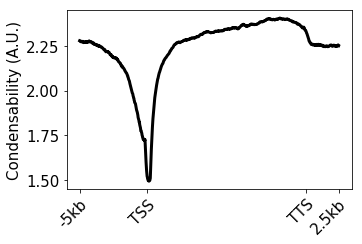

1

In [12]:
# plot mean profile
for dkey in dkey_ID_profile:
    ID_profile = dkey_ID_profile[dkey]
    mprofile = np.nanmean(ID_profile.values(), axis=0)
    mprofile = statis.moving_average(mprofile, 20)

    param = domain_param['TSS-TTS']

    graphics.plot_profile (mprofile,
                           offset=param['offset'],
                           pad_len=param['pad_len'],
                           xtick_locs=param['xtick_locs'],
                           xtick_labels=param['xtick_labels'],
                           ylabel='Condensability (A.U.)')
                           
1                           

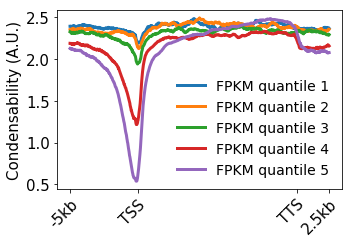

In [13]:
# partition quantiles according to gene expression level
colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for dkey in dkey_ID_profile:
    ID_profile = dkey_ID_profile[dkey]
    q_IDs = statis.quantile({ID:ID_FPKM[ID] for ID in ID_profile}, 5)

    profiles = []
    labels = []
    for i in range(len(q_IDs)):
        profile = np.nanmean([ID_profile[ID] for ID in q_IDs[i]], axis=0)
        profile = statis.moving_average(profile, 20)
        profiles.append(profile)
        labels.append('FPKM quantile %d' % (i+1))
        
    graphics.plot_profile_multiple (profiles,
                                    colors=colors,
                                    alphas=[1]*len(profiles),
                                    lws=[3]*len(profiles),
                                    labels=labels,
                                    offset=param['offset'],
                                    pad_len=param['pad_len'],
                                    xtick_locs=param['xtick_locs'],
                                    xtick_labels=param['xtick_labels'],
                                    ylabel='Condensability (A.U.)')
        
    

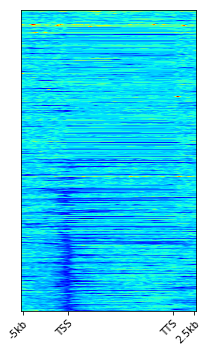

In [14]:
# plot profile heatmap
for dkey in dkey_ID_profile:
    ID_profile = dkey_ID_profile[dkey]
    FPKM_ID = sorted([(ID_FPKM[ID], ID) for ID in ID_profile])
    IDs = [ID for FPKM, ID in FPKM_ID]
    profiles = []
    for ID in IDs:
        profile = ID_profile[ID]
        profile = statis.moving_average(profile, 20)
        profiles.append(profile)

    graphics.plot_profile_heatmap (profiles,
                                   offset=param['offset'],
                                   pad_len=param['pad_len'],
                                   xtick_locs=param['xtick_locs'],
                                   xtick_labels=param['xtick_labels'])

                          
